# Deep Learning - Gesture Recognition Case Study #

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Sections:

0. **Initial EDA** This secti
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [1]:
#Install Few Dependencies if not available and validated versions

#!pip install Pillow
#!pip install imageio
#!pip install scikit-image
#!pip install tensorflow
#!pip install keras
print("*"*30)
print("Versions")
print("*"*30)
!pip freeze | grep 'scipy\|keras\|tensorflow'
!nvidia-smi

******************************
Versions
******************************
horovod @ file:///opt/tensorflow/horovod-source/dist/horovod-0.20.2.tar.gz
scipy==1.4.1
tensorflow @ file:///tmp/pip/tensorflow-2.3.1%2Bnv-cp36-cp36m-linux_x86_64.whl
tensorflow-addons @ file:///opt/tensorflow/tf-addons/artifacts/tensorflow_addons-0.11.2-cp36-cp36m-linux_x86_64.whl
tensorflow-datasets==3.2.1
tensorflow-estimator==2.3.0
tensorflow-metadata==0.25.0
Wed Jul 28 17:39:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+==================

In [3]:
#Import the necessary Libraries

import numpy as np
import os
from timeit import default_timer as timer
#from imageio import imread
import scipy
from skimage.transform import resize
import datetime
import os
from tensorflow import keras
import tensorflow as tf
import random
import glob
import cv2
import matplotlib.pyplot as plt

In [38]:
#Initialize Paths
#help(os)
#print(os.getcwd())
project_folder = '/datasets/Project_data'
train_image_metadata=project_folder+'/train.csv'
val_image_metadata=project_folder+'/val.csv'

We set the random seed so that the results don't vary drastically.

In [39]:
np.random.seed(30)
random.seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

## 0. Initial EDA 

In [40]:
train_doc = np.random.permutation(open(train_image_metadata).readlines())
val_doc = np.random.permutation(open(val_image_metadata).readlines())
#batch_size = #experiment with the batch size

In [41]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

/datasets/Project_data/train/WIN_20180925_17_49_45_Pro_Right_Swipe_new/*


Text(0.5, 0.98, 'Different Channels of Image')

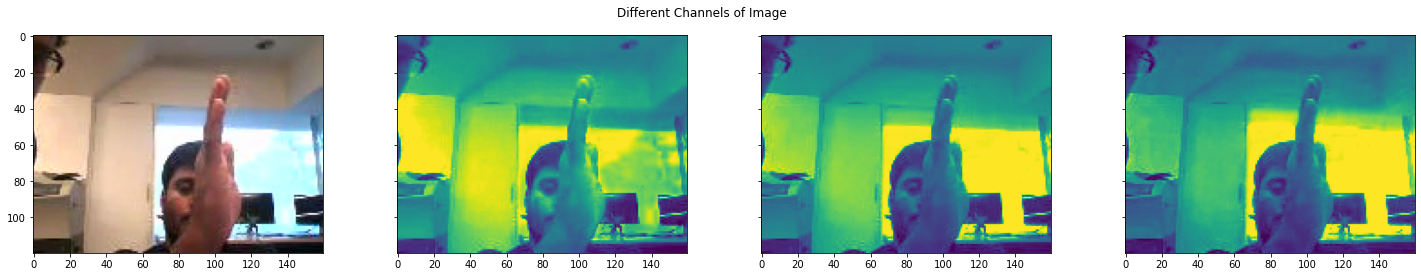

In [42]:
# run this block multiple times to look at some randomly chosen images 
rand_index = random.randint(0, len(train_doc)) # Find a random video folder 
train_path = project_folder+'/train/'+train_doc[rand_index].split(';')[0]+'/*'
print(train_path)
train_path = glob.glob(train_path) # Glob all 30 images of the folder
#print(len(train_path))
rand_index = random.randint(0, len(train_path))
image = cv2.imread(train_path[rand_index]) #Read a random image from the selected folder
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#plt.imshow(image)
#plt.show()
#image.shape
# plotting the  image and the RGB channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(25)
ax1.imshow(image)

# RGB channels
ax2.imshow(image[:, : , 0])
ax3.imshow(image[:, : , 1])
ax4.imshow(image[:, : , 2])
f.suptitle('Different Channels of Image')


(120, 160, 3)


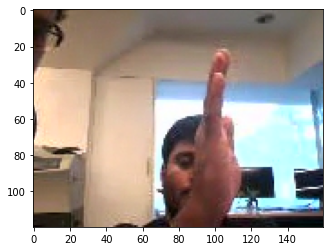

In [43]:
print(image.shape)
#crop_image=image[0:120,20:140]

plt.imshow(image)
plt.show()

(120, 120, 3)


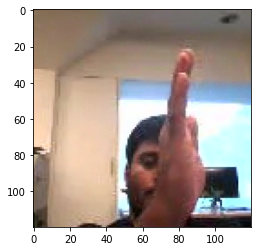

In [44]:
crop_image=image[0:120,20:140]
print(crop_image.shape)
plt.imshow(crop_image)
plt.show()

In [45]:
fliplr_thumbdown_path = glob.glob('/datasets/Project_data/train/WIN_20180925_17_57_52_Pro_Thumbs_Down_new/*')
fliplr_thumbup_path= glob.glob('/datasets/Project_data/train/WIN_20180925_17_22_42_Pro_Thumbs_Up_new/*')
fliplr_rightswipe_path=glob.glob('/datasets/Project_data/train/WIN_20180925_17_49_45_Pro_Right_Swipe_new/*')
fliplr_leftswipe_path=glob.glob('/datasets/Project_data/train/WIN_20180926_16_48_34_Pro_Left_Swipe_new/*')
crop_left_swipe = glob.glob('/datasets/Project_data/train/WIN_20180925_17_40_41_Pro_Left_Swipe_new/*')
#for path in crop_left_swipe:
#    image = cv2.imread(path) #Read a random image from the selected folder
#    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#    f.set_figwidth(15)
#    ax1.imshow(image)
#    ax2.imshow(image[0:120,20:140])
#    f.suptitle('Original Image Vs Cropped Image')
    
    
#plt.close('all')
#plt.clf()

(120, 160, 3)


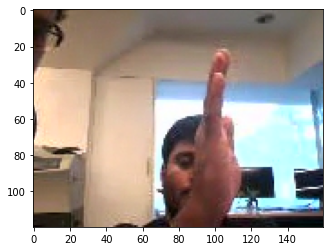

[[  1.   0.  16.]
 [  0.   1. -19.]]
Shifted (120, 160, 3)


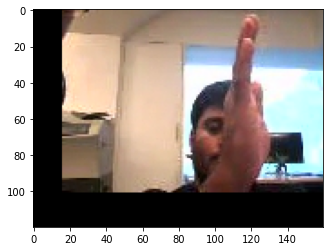

Rotated [[  0.9563047   0.2923717 -14.046682 ]
 [ -0.2923717   0.9563047  26.011452 ]]
Rotated (120, 160, 3)


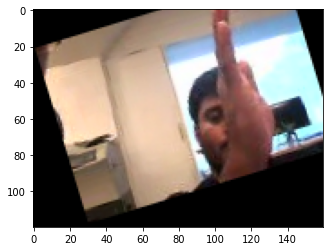

(120, 160)


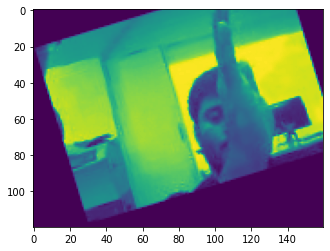

(117, 158, 3)


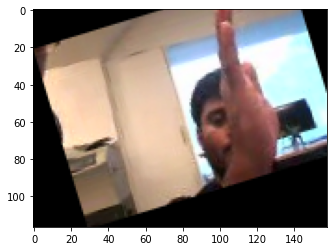

(120, 120, 3)


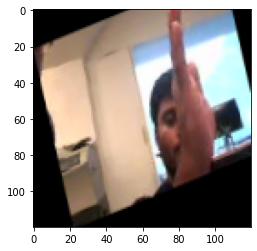

In [49]:
print(image.shape)
plt.imshow(image)
plt.show()
#crop_image=image[0:120,20:140]
#print(crop_image.shape)
#plt.imshow(crop_image)
#plt.show()
#new_image = cv2.resize(image, (120,120), interpolation = cv2.INTER_AREA)
#print(new_image.shape)
#plt.imshow(new_image)
#plt.show()
#image_resized=resize(image,(120,120,3))
#print(image_resized.shape)
#plt.imshow(image_resized)
#plt.show()
rows, cols = image.shape[:2]
 
# #https://towardsdatascience.com/transformations-with-opencv-ff9a7bea7f8b
#Then we’ll build a transformation matrix that will contain the information to transform the image. 
#For simplification, we can think of this matrix as    
    
#[[size, rotation, location], ←x-axis
#[rotation, size, location]] ←y-axis
# So default matrix will be
#[[1, 0, 0]
# [0, 1, 0]]
#That means, 100% of the size, zero rotation, and no change in the location 

# build a transformation matrix for changing location
matrix = [[1, 0, np.random.randint(-30,30)], #x 
          [0, 1, np.random.randint(-30,30)]] #y
M = np.float32(matrix)

print(M)
# Apply the affine transformation using cv2.warpAffine()
shifted = cv2.warpAffine(image, M, (cols,rows))

print("Shifted",shifted.shape)
plt.imshow(shifted)
plt.show()

# build a transformation matrix for rotation
#rot_matrix = [[1, 10, 0], #x 
#          [10, 1, 0]] #y


rot_matrix = cv2.getRotationMatrix2D((cols//2,rows//2),
                                                np.random.randint(-20,20), 1)
rot_M = np.float32(rot_matrix)


print("Rotated",rot_M)
# Apply the affine transformation using cv2.warpAffine()
rotated = cv2.warpAffine(shifted, rot_M, (cols,rows))
print("Rotated",rotated.shape)
plt.imshow(rotated)
plt.show()

gray = cv2.cvtColor(rotated,cv2.COLOR_RGB2GRAY)
print(gray.shape)
plt.imshow(gray)
plt.show()

x0, y0 = np.argwhere(gray > 0).min(axis=0)
x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                  
cropped=rotated[x0:x1,y0:y1,:]
print(cropped.shape)
plt.imshow(cropped)
plt.show()

new_image = cv2.resize(cropped, (120,120), interpolation = cv2.INTER_AREA)
print(new_image.shape)
plt.imshow(new_image)
plt.show()





## 1. Generator
In the generator, we are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. We will experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [24]:
#Base Class for all the classes with common functionality
import abc
class BaseModel(metaclass=abc.ABCMeta):
    
    
    def __init__(self):
        # object attributes
        self.name = 'Green'
        self.timing_cb = self.TimingCallback()
        
        
    #initialize the path for the train and validation images
    #This will be called by each inherited class
    def initialize_path(self, project_folder):
        self.train_doc = np.random.permutation(open(train_image_metadata).readlines())
        self.val_doc = np.random.permutation(open(val_image_metadata).readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    
    #initialize the properties of each image
    #We will standardize all image using the 
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    
    #initalize the training parameters, this will be used by  each model to train 
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    def generator(self, source_path, folder_list, augment=False):
        batch_size = self.batch_size
        #print('Source path = ', source_path)
        #print('batch size =', batch_size)
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        while True:
            t = np.random.permutation(folder_list)
            #print("t : ", t)
            num_batches =  len(t)//batch_size
            #print("num_batches", num_batches)
            
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data, batch_labels= self.one_batch_data_generator(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 
                
            
            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data_generator(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
                
                
    
    def one_batch_data_generator(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq=0):
        
        #Initialize the seq length
        seq_len = remaining_seq if remaining_seq else batch_size
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((seq_len,self.num_classes)) # batch_labels is the one hot representation of the output

        
        if (augment): 
            batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
            batch_data_rot = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
        
        for folder in range(seq_len): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    # 360 x 360 and 120 x 160 and 
                    # the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # Crop the image which doesn't have aspect ratio of 1
                    # In the data set 120x160 will be those, we will adjust the width by trimming
                    # 20 pixels from both left and right side and making it a 120x120 image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,20:140]
                        
                    #As we are shrinking the image so using Interpolation as "INTER_AREA"
                    image_resized = cv2.resize(image, (self.image_width, self.image_height), interpolation = cv2.INTER_AREA)
           
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                    if (augment):
                        # #https://towardsdatascience.com/transformations-with-opencv-ff9a7bea7f8b
                        #We’ll build a transformation matrix that will contain the information to 
                        #transform the image. 
                        #For simplification, we can think of this matrix as    
    
                        #[[size, rotation, location], ←x-axis
                        #[rotation, size, location]] ←y-axis
                        # So default matrix will be
                        #[[1, 0, 0]
                        # [0, 1, 0]]
                        #That means, 100% of the size, zero rotation, and no change in the location 

                        # build a transformation matrix
                        # We will do random location change in the range of -30 to 30 for both x and y axis
                        translation_matrix = np.array([
                                 [1, 0, np.random.randint(-30,30)], #x 
                                 [0, 1, np.random.randint(-30,30)]  #y
                        ], dtype=np.float32) 
                                                
                        rows, cols = image.shape[:2] # Height, Width
                        # Apply the affine transformation using cv2.warpAffine()
                        # cv2 needs dimensions in Width, Height formats
                        transformed = cv2.warpAffine(image, translation_matrix, (cols,rows))
                        
                        #Convert to grayscale to crop out black borders if any
                        gray = cv2.cvtColor(transformed,cv2.COLOR_RGB2GRAY)

                        # Find min and max from pixels whose intensity is not zero.
                        # Black will be zero
                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                        cropped=transformed[x0:x1,y0:y1,:]
                    
                        image_resized = cv2.resize(cropped, (self.image_width, self.image_height), interpolation = cv2.INTER_AREA)
                      
                        batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                        
                        #Rotate image at an angle between -10 to 10 
                        rotate_matrix = cv2.getRotationMatrix2D((cols//2,rows//2),
                                                np.random.randint(-10,10), 1.0)
                        rotated = cv2.warpAffine(image, rotate_matrix, (cols, rows)) 
                        
                        rotated_resized = cv2.resize(rotated, (self.image_width, self.image_height), interpolation = cv2.INTER_AREA)
                        
                        batch_data_rot[folder,idx,:,:,0] = (rotated_resized[:,:,0])/255
                        batch_data_rot[folder,idx,:,:,1] = (rotated_resized[:,:,1])/255
                        batch_data_rot[folder,idx,:,:,2] = (rotated_resized[:,:,2])/255
                                               
    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

        #Add to the augmentated labels also if augmented is true
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_data=np.concatenate([batch_data,batch_data_rot])
            batch_labels=np.tile(batch_labels,(3,1)) # Create Label by repeating the batch_label 3 times
            

        return (batch_data, batch_labels)
    
    def train_model(self, model, augment_data = False):
        train_generator = self.generator(self.train_path, self.train_doc, augment= augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)
        
        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        
        if not os.path.exists(model_name):
            os.mkdir(model_name)
            
        filepath = 'model_init' + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}--{val_categorical_accuracy:.5f}.h5'
        
        #HyperParameter Tuners
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', min_dela=0, patience=5, verbose=1)
        earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1)
        
        callbacks_list = [checkpoint, LR, earlystop, self.timing_cb]
        
        #The `steps_per_epoch` and `validation_steps` are used by 
        #fit_generator to decide the number of next() calls it need to make.
        
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
            
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history   
    
    
    #Class to calculate the time taken for training each epoch
    class TimingCallback(keras.callbacks.Callback):
        def __init__(self, logs={}):
            self.logs=[]
        def on_epoch_begin(self, epoch, logs={}):
            self.starttime = timer()
        def on_epoch_end(self, epoch, logs={}):
            self.logs.append(timer()-self.starttime)
    
    
    @abc.abstractmethod
    def define_model(self):
        pass   
    
    

#### Plotting Function for Results ####

In [16]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## 2. Model
Here we will make the model using different functionalities that Keras provides. We will use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. 
We will also try building a `Conv2D + RNN model`. The last layer is the softmax. We will try to design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
#Common Import for Models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers



### Initial Model : 0

In [26]:
class ModelConv3D_Inital(BaseModel):
    
    def define_model(self):
        model = Sequential()
        model.add(Conv3D(16, (3,3,3), padding='same',
                        input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,(2,2,2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimizer = optimizers.Adam()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

Assembling Initial Model :

In [18]:
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=160, image_width=160)
conv3d_initial.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=1)
conv3d_initial_model = conv3d_initial.define_model()
conv3d_initial_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 160, 160, 16)  64        
_________________________________________________________________
activation (Activation)      (None, 16, 160, 160, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 80, 80, 32)     4128      
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 80, 80, 32)     128       
_________________________________________________________________
activation_1 (Activation)    (None, 8, 80, 80, 32)     0

Validating if this model compiles

In [19]:
conv3d_initial.train_model(conv3d_initial_model)

23/23 [==============================] - ETA: 0s - loss: 1.9789 - categorical_accuracy: 0.3122
Epoch 00001: val_loss improved from inf to 2.56263, saving model to model_initmodel-00001-1.97891-0.31222-2.56263--0.16000.h5
23/23 [==============================] - 40s 2s/step - loss: 1.9789 - categorical_accuracy: 0.3122 - val_loss: 2.5626 - val_categorical_accuracy: 0.1600


**Observation**  : We have now created an initial model which is compilable 

We shall now look at an optimum **initial** value for all the hyperparameters which gives us a good balance between time taken and accuracy.
- **Step 1**:  We will find the Optimum Value by analysing **Epoch Time** by, with changing few parameters linearly, and while keeping others fixed. This will be done. This will help us analyse the tradeoff of varying these values, and fix the initial values for the parameters
- **Step 2**: Next, Using these parameters we will first train for 20 epochs and see if the Training Set overlearns, which means that the model is working, when we shall move to step 3
- **Step 3** We will now look at various parameters and architectures in that order, and try to optimise it to reduce loss and increase training effeciency


### Step 1: Tradeoff Analysis
Analysing Tradeoff between Image Resolution, Number of Images and Batch Size

**Approach** : We will first Decrease the Batch Parameters,then Increase the Resolution of the Images, and then play around with the Frames. 
At each step, We will analyse the time for each Epoch and Total time, to see if this makes a difference to the training time.  Using this we will try to guestimate the parameters we should start with

We will use limited epochs, for the training as that is not important for this experiment

In [69]:
#Baseline
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=100, image_width=100)
conv3d_initial.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv3d_initial_model = conv3d_initial.define_model()
#conv3d_initial_model.summary()
conv3d_initial.train_model(conv3d_initial_model)
print("Per Epoch time  {}".format(conv3d_initial.timing_cb.logs))
print("Total Time: {}".format(sum(conv3d_initial.timing_cb.logs)))


Timing Callback Initialized
tcb:Begin
Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 1.7990 - categorical_accuracy: 0.3544
Epoch 00001: val_loss improved from inf to 1.80771, saving model to model_initmodel-00001-1.79904-0.35445-1.80771--0.19000.h5
tcb:End
23/23 [==============================] - 34s 1s/step - loss: 1.7990 - categorical_accuracy: 0.3544 - val_loss: 1.8077 - val_categorical_accuracy: 0.1900
tcb:Begin
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 1.3893 - categorical_accuracy: 0.4585
Epoch 00002: val_loss did not improve from 1.80771
tcb:End
23/23 [==============================] - 34s 1s/step - loss: 1.3893 - categorical_accuracy: 0.4585 - val_loss: 3.4359 - val_categorical_accuracy: 0.1400
tcb:Begin
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 1.1033 - categorical_accuracy: 0.5596
Epoch 00003: val_loss did not improve from 1.80771
tcb:End
23/23 [==============================] - 34s 1s/step - loss: 1.1033 -

In [64]:
#Reduce Batch Size from 30 to 20
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=100, image_width=100)
conv3d_initial.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=3)
conv3d_initial_model = conv3d_initial.define_model()
#conv3d_initial_model.summary()
conv3d_initial.train_model(conv3d_initial_model)
print("Per Epoch time  {}".format(conv3d_initial.timing_cb.logs))
print("Total Time: {}".format(sum(conv3d_initial.timing_cb.logs)))

Timing Callback Initialized
tcb:Begin
Epoch 1/3
33/34 [============================>.] - ETA: 0s - loss: 2.0022 - categorical_accuracy: 0.3288
Epoch 00001: val_loss improved from inf to 2.75967, saving model to model_initmodel-00001-2.00062-0.32730-2.75967--0.16000.h5
tcb:End
34/34 [==============================] - 36s 1s/step - loss: 2.0006 - categorical_accuracy: 0.3273 - val_loss: 2.7597 - val_categorical_accuracy: 0.1600
tcb:Begin
Epoch 2/3
34/34 [==============================] - ETA: 0s - loss: 1.1352 - categorical_accuracy: 0.6018
Epoch 00002: val_loss did not improve from 2.75967
tcb:End
34/34 [==============================] - 36s 1s/step - loss: 1.1352 - categorical_accuracy: 0.6018 - val_loss: 4.5026 - val_categorical_accuracy: 0.1700
tcb:Begin
Epoch 3/3
34/34 [==============================] - ETA: 0s - loss: 1.0877 - categorical_accuracy: 0.6063
Epoch 00003: val_loss did not improve from 2.75967
tcb:End
34/34 [==============================] - 34s 1s/step - loss: 1.0877 -

In [66]:
#Increase Image Resoultion to 160
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=160, image_width=160)
conv3d_initial.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=3)
conv3d_initial_model = conv3d_initial.define_model()
#conv3d_initial_model.summary()
conv3d_initial.train_model(conv3d_initial_model)
print("Per Epoch time  {}".format(conv3d_initial.timing_cb.logs))
print("Total Time: {}".format(sum(conv3d_initial.timing_cb.logs)))

Timing Callback Initialized
tcb:Begin
Epoch 1/3
34/34 [==============================] - ETA: 0s - loss: 1.8168 - categorical_accuracy: 0.3876
Epoch 00001: val_loss improved from inf to 4.10563, saving model to model_initmodel-00001-1.81678-0.38763-4.10563--0.21000.h5
tcb:End
34/34 [==============================] - 41s 1s/step - loss: 1.8168 - categorical_accuracy: 0.3876 - val_loss: 4.1056 - val_categorical_accuracy: 0.2100
tcb:Begin
Epoch 2/3
33/34 [============================>.] - ETA: 1s - loss: 1.1518 - categorical_accuracy: 0.6015
Epoch 00002: val_loss did not improve from 4.10563
tcb:End
34/34 [==============================] - 40s 1s/step - loss: 1.1572 - categorical_accuracy: 0.6018 - val_loss: 6.3096 - val_categorical_accuracy: 0.2000
tcb:Begin
Epoch 3/3
33/34 [============================>.] - ETA: 1s - loss: 0.9794 - categorical_accuracy: 0.6455
Epoch 00003: val_loss did not improve from 4.10563
tcb:End
34/34 [==============================] - 42s 1s/step - loss: 0.9762 -

In [70]:
#Double No of Frames to Half
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=160, image_width=160)
conv3d_initial.initialize_hyperparams(frames_to_sample=32,batch_size=20,num_epochs=3)
conv3d_initial_model = conv3d_initial.define_model()
#conv3d_initial_model.summary()
conv3d_initial.train_model(conv3d_initial_model)
print("Per Epoch time  {}".format(conv3d_initial.timing_cb.logs))
print("Total Time: {}".format(sum(conv3d_initial.timing_cb.logs)))

Timing Callback Initialized
tcb:Begin
Epoch 1/3
34/34 [==============================] - ETA: 0s - loss: 1.8887 - categorical_accuracy: 0.4042
Epoch 00001: val_loss improved from inf to 3.01010, saving model to model_initmodel-00001-1.88874-0.40422-3.01010--0.21000.h5
tcb:End
34/34 [==============================] - 77s 2s/step - loss: 1.8887 - categorical_accuracy: 0.4042 - val_loss: 3.0101 - val_categorical_accuracy: 0.2100
tcb:Begin
Epoch 2/3
34/34 [==============================] - ETA: 0s - loss: 1.3780 - categorical_accuracy: 0.5264
Epoch 00002: val_loss did not improve from 3.01010
tcb:End
34/34 [==============================] - 78s 2s/step - loss: 1.3780 - categorical_accuracy: 0.5264 - val_loss: 4.2782 - val_categorical_accuracy: 0.2100
tcb:Begin
Epoch 3/3
34/34 [==============================] - ETA: 0s - loss: 0.9874 - categorical_accuracy: 0.6214
Epoch 00003: val_loss did not improve from 3.01010
tcb:End
34/34 [==============================] - 78s 2s/step - loss: 0.9874 -

**Observation**

- The batch size didnt significantly impact the performance - We can stick to **40** for now, so that we have maximum parallelism
- The resolution of the image impacts the training time. We can stick to the medium-high resolution of **160*160** 
- The No of Frames parameter is also directly impacting time to train. This is understandable. Considering we have 30 images, we can now sample 1/3 **20 Frames** in each video

#### Step 2: 
We will now train the model with the above parameters for 10 epochs, and see if the model is learning. We expect this model to overfit, and if that happens then we are on the right track. 
We will also try to augment the images and validate the same over a few epochs
If the assumptions are validated, then we will run this model over a 20 epochs and establish our baseline model which we improve over the next iterations

In [28]:
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=160, image_width=160)
conv3d_initial.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=10)
conv3d_initial_model = conv3d_initial.define_model()
conv3d_initial_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
batch_normalization_18 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
activation_12 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 10, 80, 80, 32)    4128      
_________________________________________________________________
batch_normalization_19 (Batc (None, 10, 80, 80, 32)    128       
_________________________________________________________________
activation_13 (Activation)   (None, 10, 80, 80, 32)   

In [14]:
print("Total Params:", conv3d_initial_model.count_params())
history_model_initial = conv3d_initial.train_model(conv3d_initial_model)

Total Params: 1736389
Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 1.8126 - categorical_accuracy: 0.3982
Epoch 00001: val_loss improved from inf to 1.85548, saving model to model_initmodel-00001-1.81263-0.39819-1.85548--0.24000.h5
17/17 [==============================] - 49s 3s/step - loss: 1.8126 - categorical_accuracy: 0.3982 - val_loss: 1.8555 - val_categorical_accuracy: 0.2400
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 1.2397 - categorical_accuracy: 0.5490
Epoch 00002: val_loss did not improve from 1.85548
17/17 [==============================] - 51s 3s/step - loss: 1.2397 - categorical_accuracy: 0.5490 - val_loss: 3.1758 - val_categorical_accuracy: 0.2300
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 0.9357 - categorical_accuracy: 0.6365
Epoch 00003: val_loss did not improve from 1.85548
17/17 [==============================] - 48s 3s/step - loss: 0.9357 - categorical_accuracy: 0.6365 - val_loss: 4.6180 - val_ca

Per Epoch time  [54.83856205199845, 51.461848876904696, 48.40349404304288, 48.4170288129244, 50.01310895988718, 47.46483541605994]
Total Time: 300.59887816081755


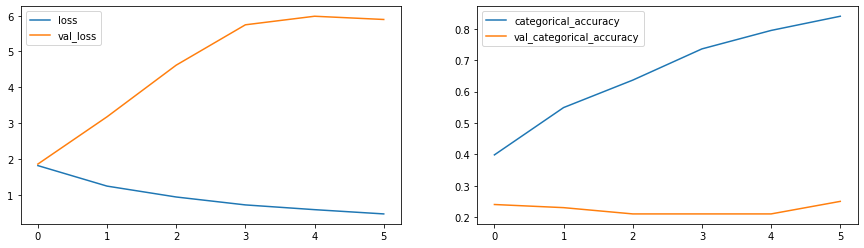

In [18]:
print("Per Epoch time  {}".format(conv3d_initial.timing_cb.logs))
print("Total Time: {}".format(sum(conv3d_initial.timing_cb.logs)))
plot(history_model_initial)

In [32]:
#Reducing Batch size to remove OOM Error
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=160, image_width=160)
conv3d_initial.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=10)
conv3d_initial_model = conv3d_initial.define_model()
#conv3d_initial_model.summary()

In [33]:
history_model_initial_with_aug = conv3d_initial.train_model(conv3d_initial_model, augment_data = True)

Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.7795 - categorical_accuracy: 0.3906
Epoch 00001: val_loss improved from inf to 4.14103, saving model to model_initmodel-00001-1.77955-0.39065-4.14103--0.16000.h5
34/34 [==============================] - 122s 4s/step - loss: 1.7795 - categorical_accuracy: 0.3906 - val_loss: 4.1410 - val_categorical_accuracy: 0.1600
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.1693 - categorical_accuracy: 0.5646
Epoch 00002: val_loss did not improve from 4.14103
34/34 [==============================] - 124s 4s/step - loss: 1.1693 - categorical_accuracy: 0.5646 - val_loss: 5.6697 - val_categorical_accuracy: 0.2000
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.9495 - categorical_accuracy: 0.6315
Epoch 00003: val_loss did not improve from 4.14103
34/34 [==============================] - 124s 4s/step - loss: 0.9495 - categorical_accuracy: 0.6315 - val_loss: 6.9522 - val_categorical_accuracy:

Per Epoch time  [125.7620007158257, 124.79694301495329, 124.81074279500172, 120.08627714100294, 119.58311346708797, 120.1390272860881]
Total Time: 735.1781044199597


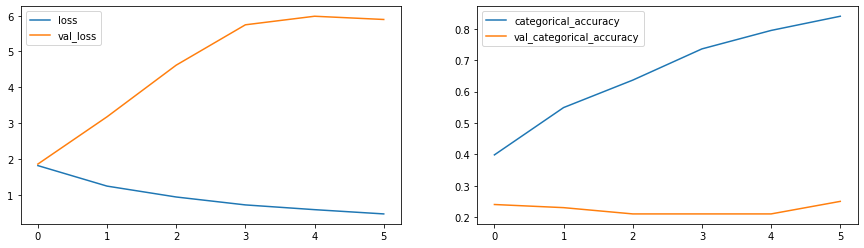

In [34]:
print("Per Epoch time  {}".format(conv3d_initial.timing_cb.logs))
print("Total Time: {}".format(sum(conv3d_initial.timing_cb.logs)))
plot(history_model_initial)

**Observation**
- The model is clearly learning, and also clearly overfitting. This the intended outcome. 
- Augmentation is taking **more than double the time** for training, with a minor improvement in accuracy. So we will first be training without augmenation, and then adding augmentation as the last step.

### Step 3: 
We will now train the model with the above parameters for larger epochs and establish the baseline. As we have observed the model was overfitting, so we will add a droput layer in our baseline
Post that we will improve on our baseline by using various experiments


#### Model 1 ####
- Image - 160*160
- Batch Size - 40
- Num of Epochs - 15
- Dropouts - 0.25
- Dense Neurons - 64

In [19]:
#Baseline Model Definition

class ModelConv3D1(BaseModel):
    
    #We will also add a standard filtersize and dropout to generalize
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
#Baseline Model
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_9 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 10, 80, 80, 32)   

In [21]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.5892 - categorical_accuracy: 0.3952
Epoch 00001: val_loss improved from inf to 2.59173, saving model to model_initmodel-00001-1.58922-0.39517-2.59173--0.18000.h5
17/17 [==============================] - 49s 3s/step - loss: 1.5892 - categorical_accuracy: 0.3952 - val_loss: 2.5917 - val_categorical_accuracy: 0.1800
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.9899 - categorical_accuracy: 0.5882
Epoch 00002: val_loss improved from 2.59173 to 1.67940, saving model to model_initmodel-00002-0.98985-0.58824-1.67940--0.36000.h5
17/17 [==============================] - 49s 3s/step - loss: 0.9899 - categorical_accuracy: 0.5882 - val_loss: 1.6794 - val_categorical_accuracy: 0.3600
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.7517 - categorical_accuracy: 0.7134
Epoch 00003: val_loss did not improve from 1.67940
17/17 [==============================] - 48s 3s

Per Epoch time  [51.63052674988285, 49.09105406003073, 47.948106440017, 48.71655281120911, 49.16121789906174, 47.92729807505384, 49.111282533966005]
Total Time: 343.5860385692213


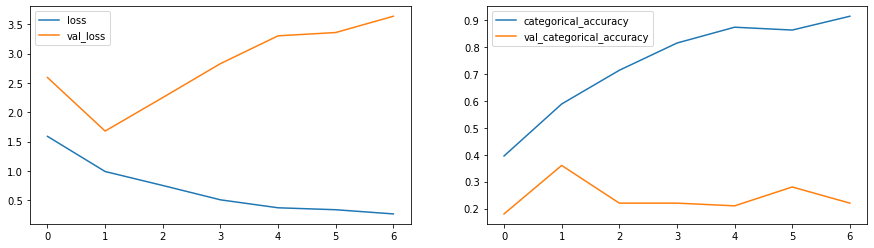

In [23]:
print("Per Epoch time  {}".format(conv_3d1.timing_cb.logs))
print("Total Time: {}".format(sum(conv_3d1.timing_cb.logs)))
plot(history_model1)

**Observation** 
- The baseline model is established. Clearly the model is overfitting, 
- We have an accuracy of 0.58 and validation loss of 1.67

#### Model 2 ####
We will try to add more dropouts and dense layers to reduce overfitting
- Image - 160*160
- Batch Size - 40
- Num of Epochs - 25
- Dropouts - 0.5
- Dense Neurons - 256

In [50]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_28 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_28 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_29 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 10, 80, 80, 32)   

In [51]:
print("Total Params:", conv_3d2_model.count_params())
history_model2 = conv_3d2.train_model(conv_3d1_model)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 0.1844 - categorical_accuracy: 0.9517
Epoch 00001: val_loss improved from inf to 3.77069, saving model to model_initmodel-00001-0.18437-0.95173-3.77069--0.27000.h5
34/34 [==============================] - 48s 1s/step - loss: 0.1844 - categorical_accuracy: 0.9517 - val_loss: 3.7707 - val_categorical_accuracy: 0.2700
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 0.1688 - categorical_accuracy: 0.9668
Epoch 00002: val_loss improved from 3.77069 to 3.72427, saving model to model_initmodel-00002-0.16883-0.96682-3.72427--0.27000.h5
34/34 [==============================] - 48s 1s/step - loss: 0.1688 - categorical_accuracy: 0.9668 - val_loss: 3.7243 - val_categorical_accuracy: 0.2700
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.2134 - categorical_accuracy: 0.9382
Epoch 00003: val_loss improved from 3.72427 to 3.43388, saving model to model_initmodel-00003-0.21

Per Epoch time  [51.63052674988285, 49.09105406003073, 47.948106440017, 48.71655281120911, 49.16121789906174, 47.92729807505384, 49.111282533966005]
Total Time: 343.5860385692213


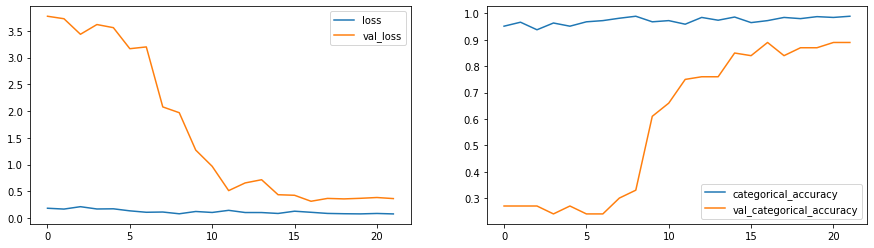

In [52]:
print("Per Epoch time  {}".format(conv_3d1.timing_cb.logs))
print("Total Time: {}".format(sum(conv_3d1.timing_cb.logs)))
plot(history_model2)

**Observation**:
  - The model generalized pretty much due to the combination of droputs and fully connected layers
  - Validation loss is at 0.31 and Accuracy is at 0.97 which is much better than the previous model

#### Model 3 ####
We will try to increase the size of the convolution filter to see if there is a a better generalization
- Image - 160*160
- Batch Size - 40
- Num of Epochs - 25
- Dropouts - 0.5
- Dense Neurons - 256